In [1]:
from pathlib import Path
from io_f import read_data_file, read_path_data, get_gt_path, get_sensor_values

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

floor_data_dir = "./data/site1/F1"
path_data_dir = floor_data_dir + "/path_data_files"

path_filenames = list(Path(path_data_dir).resolve().glob("*.txt"))



In [2]:
def extract_wifi(df):
    
    # TODO: add linear interpolation, based on timestamp
    df.loc[:, ["X", "Y"]] = df.loc[:, ["X", "Y"]].fillna(method="ffill")
    df = df.drop_duplicates(subset=["X", "Y", "BSSID"])
    wifis = {}
    for hotspot, signatures in df.groupby("BSSID"):
        wifis[hotspot] = [tuple(sig) for sig in signatures[["X", "Y", "WIFI_RSSI"]].to_numpy()]
        
    return wifis

In [3]:
def visualize_bssid_observations(bssid, observations, color="blue"):
    print(f"{bssid} has {len(observations)} observations")
    xs = [obv[0] for obv in observations]
    ys = [obv[1] for obv in observations]
    strength = [obv[2] for obv in observations]
    plt.scatter(xs, ys, s=np.log(np.abs(strength)), color=color)
    plt.show()

In [4]:
wifis = {}
for i, path_filename in enumerate(path_filenames[:10]):
    print(f"Processing file: {path_filename}...")
    metadata, sensor_data = read_path_data(path_filename, i)
    
    col_types = {}
    for col in sensor_data.columns:
        if col not in ["TIMESTAMP", "SSID", "BSSID", "LASTSEEN_TS"]:
            col_types[col] = "float32"
        sensor_data = sensor_data.astype(col_types)
        
    path_wifis = extract_wifi(sensor_data)
    for bssid, path_observations in path_wifis.items():
        observations = wifis.get(bssid, [])
        observations.extend(path_observations)
        wifis[bssid] = observations
#     visualize_wifis(wifis)

Processing file: /Users/li-wei/fun/indoor-location-competition-20/data/site1/F1/path_data_files/5dd9fd5ec5b77e0006b173da.txt...
reading from /Users/li-wei/fun/indoor-location-competition-20/data/site1/F1/path_data_files/5dd9fd5ec5b77e0006b173da.txt...
Processing file: /Users/li-wei/fun/indoor-location-competition-20/data/site1/F1/path_data_files/5dd9fd649191710006b570f4.txt...
reading from /Users/li-wei/fun/indoor-location-competition-20/data/site1/F1/path_data_files/5dd9fd649191710006b570f4.txt...
Processing file: /Users/li-wei/fun/indoor-location-competition-20/data/site1/F1/path_data_files/5dd9fd4ec5b77e0006b173ce.txt...
reading from /Users/li-wei/fun/indoor-location-competition-20/data/site1/F1/path_data_files/5dd9fd4ec5b77e0006b173ce.txt...
Processing file: /Users/li-wei/fun/indoor-location-competition-20/data/site1/F1/path_data_files/5dd9fd47c5b77e0006b173c8.txt...
reading from /Users/li-wei/fun/indoor-location-competition-20/data/site1/F1/path_data_files/5dd9fd47c5b77e0006b173c8

In [5]:
sensor_data.loc[:, "WIFI_RSSI"].isnull()  

12       True
14       True
15       True
16       True
17       True
         ... 
13824    True
13825    True
13826    True
13827    True
13828    True
Name: WIFI_RSSI, Length: 13136, dtype: bool

00:1f:7a:4d:6b:30 has 10 observations


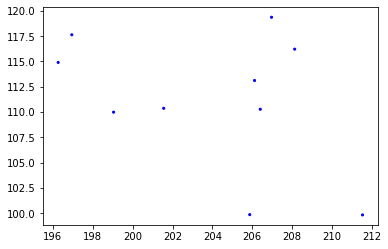

In [142]:
sample_bssid = list(wifis.keys())[0]
visualize_bssid_observations(sample_bssid, wifis[sample_bssid])

In [147]:
def wifi_summary(wifis):
    stats = {}
    for wifi, observations in wifis.items():
        stat = stats.setdefault(wifi, {})
        stat["num_obvs"] = len(observations)
    
    # report number of observations
    print("Number of Observations Quantile Report: ")
    quantiles = np.arange(0, 1, 0.1)
    qvals = np.quantile([stat["num_obvs"] for stat in stats.values()], quantiles)
    for quantile, qval in zip(quantiles, qvals):
        print(f"Quantile {quantile}: {qval}")
    return qvals

In [148]:
qvals = wifi_summary(wifis)

Number of Observations Quantile Report: 
Quantile 0.0: 1.0
Quantile 0.1: 4.0
Quantile 0.2: 6.0
Quantile 0.30000000000000004: 9.0
Quantile 0.4: 12.0
Quantile 0.5: 17.0
Quantile 0.6000000000000001: 21.0
Quantile 0.7000000000000001: 27.0
Quantile 0.8: 35.0
Quantile 0.9: 44.0


In [173]:
well_observed_wifis = filter(lambda x: len(wifis[x]) > qvals[-1], wifis)

In [158]:
def select_wifis(wifis, names):
    selected_wifis = {}
    for n in names:
        selected_wifis[n] = wifis[n]
    return selected_wifis

In [174]:
wifis_1 = select_wifis(wifis, well_observed_wifis)

00:74:9c:be:25:66 has 49 observations


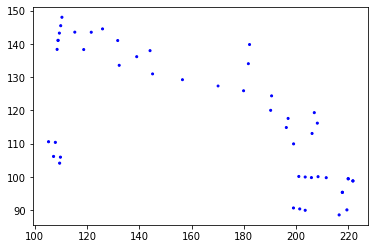

In [177]:
sample_bssid = list(wifis_1.keys())[0]
visualize_bssid_observations(sample_bssid, wifis_1[sample_bssid])

In [178]:
wifis_1

{'00:74:9c:be:25:66': [(196.26472, 114.8901, -61.0),
  (196.94728, 117.62149, -60.0),
  (208.12675, 116.20255, -66.0),
  (206.11342, 113.105, -66.0),
  (144.13603, 137.96576, -62.0),
  (139.03607, 136.15617, -62.0),
  (131.76631, 141.00772, -61.0),
  (125.959595, 144.50266, -61.0),
  (121.642624, 143.50314, -66.0),
  (115.356514, 143.5269, -63.0),
  (110.4311, 147.99918, -71.0),
  (109.96377, 145.45828, -69.0),
  (109.44802, 143.23576, -68.0),
  (108.944084, 141.0568, -68.0),
  (108.583046, 138.3496, -68.0),
  (181.7437, 134.0519, -49.0),
  (182.19794, 139.80661, -56.0),
  (217.70581, 95.42725, -90.0),
  (221.73817, 98.85731, -90.0),
  (219.94281, 99.502945, -90.0),
  (198.99812, 90.73314, -75.0),
  (201.40259, 90.44333, -75.0),
  (203.48418, 90.0386, -67.0),
  (201.04163, 100.19572, -67.0),
  (203.48045, 100.029144, -67.0),
  (205.87306, 99.85177, -67.0),
  (199.0444, 109.97728, -67.0),
  (208.40327, 100.12318, -66.0),
  (211.53053, 99.82375, -66.0),
  (206.96545, 119.354294, -65.0),


In [ ]:
def estimate_wifi_position(obvs):
    